#  MRI Brain Tumor Detection using Deep Learning and Machine Learning

This notebook implements the pipeline proposed in the research paper:
**"MRI brain tumor detection using deep learning and machine learning approaches"**.

We'll use Adaptive Contrast Enhancement, Fuzzy C-Means clustering, GLCM feature extraction, and an Ensemble Deep Neural Support Vector Machine (EDN-SVM) classifier.

In [1]:
!conda install -c conda-forge scikit-image

Channels:
 - conda-forge
 - defaults
Platform: win-64
Solving environment: ...working... done

# All requested packages already installed.



In [2]:
!pip install --upgrade scikit-image

In [3]:
!pip uninstall scikit-image -y
!pip install scikit-image

Found existing installation: scikit-image 0.25.2
Uninstalling scikit-image-0.25.2:
  Successfully uninstalled scikit-image-0.25.2
  Using cached scikit_image-0.25.2-cp312-cp312-win_amd64.whl.metadata (14 kB)
Using cached scikit_image-0.25.2-cp312-cp312-win_amd64.whl (12.9 MB)


In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from skimage.feature import graycomatrix, graycoprops
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from fcmeans import FCM


In [5]:
def load_data(folder, classes, img_size=(128, 128)):
    images, labels = [], []
    for label, cls in enumerate(classes):
        class_path = os.path.join(folder, cls)
        for file in os.listdir(class_path):
            img = load_img(os.path.join(class_path, file), color_mode='grayscale', target_size=img_size)
            img = img_to_array(img) / 255.0
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

train_path = "Training"
test_path = "Testing"
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

X_train, y_train = load_data(train_path, class_names)
X_test, y_test = load_data(test_path, class_names)

print(f"Training samples: {X_train.shape}, Testing samples: {X_test.shape}")


Training samples: (5712, 128, 128, 1), Testing samples: (1311, 128, 128, 1)


##  Preprocessing - Adaptive Contrast Enhancement & Median Filtering

In [6]:
def preprocess(img):
    img = (img * 255).astype(np.uint8).squeeze()
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(img)
    denoised = cv2.medianBlur(enhanced, 3)
    return denoised

X_train_prep = np.array([preprocess(img) for img in X_train])
X_test_prep = np.array([preprocess(img) for img in X_test])


## Segmentation using Fuzzy C-Means Clustering

In [7]:
from tqdm import tqdm

def fcm_segment(img, n_clusters=3):
    """
    Applies fuzzy c-means segmentation on a smaller version of the image.
    Returns segmentation mapped back to original resolution.
    """
    # Resize for faster computation
    small = cv2.resize(img, (64, 64))
    flat = small.flatten().reshape(-1, 1)

    # Fuzzy clustering
    fcm = FCM(n_clusters=n_clusters, max_iter=50, error=0.005, random_state=0)
    fcm.fit(flat)

    # Get cluster labels and reshape
    segmented = fcm.u.argmax(axis=1).reshape(small.shape)

    # Resize segmented image back to original size
    segmented_resized = cv2.resize(segmented.astype(np.uint8), img.shape[::-1], interpolation=cv2.INTER_NEAREST)
    return segmented_resized


##  Feature Extraction using GLCM

In [8]:
def extract_glcm(img):
    glcm = graycomatrix(img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    return [
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'energy')[0, 0],
        graycoprops(glcm, 'correlation')[0, 0],
        -np.sum(glcm * np.log2(glcm + 1e-10))  # Entropy
    ]



In [ ]:
from tqdm import tqdm

def get_glcm_features(image_set):
    """
    This function processes a set of images to extract GLCM features
    from the most relevant segmented region.
    """
    all_glcm_features = []
    

    for img in tqdm(image_set, desc="Extracting GLCM Features"):

        segmented_img = fcm_segment(img, n_clusters=3)

        tumor_cluster_label = np.argmax([img[segmented_img == i].mean() for i in range(3)])
        

        tumor_mask = (segmented_img == tumor_cluster_label).astype(np.uint8)
        
        tumor_only_img = img * tumor_mask
        

        glcm_features = extract_glcm(tumor_only_img)
        all_glcm_features.append(glcm_features)
        
    return np.array(all_glcm_features)

X_train_glcm = get_glcm_features(X_train_prep)
X_test_glcm = get_glcm_features(X_test_prep)

print(f"Shape of GLCM training features: {X_train_glcm.shape}")
print(f"Shape of GLCM testing features: {X_test_glcm.shape}")

Extracting GLCM Features: 100%|██████████| 1311/1311 [00:25<00:00, 50.61it/s]

Shape of GLCM training features: (5712, 4)
Shape of GLCM testing features: (1311, 4)


## CNN Feature Extraction + SVM Classification (EDN-SVM Simulation)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# Data preparation
X_train_reshaped = X_train_prep.reshape(-1, 128, 128, 1)
X_test_reshaped = X_test_prep.reshape(-1, 128, 128, 1)
num_classes = len(class_names)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))


# CNN architecture
cnn_input = Input(shape=(128, 128, 1))
x = Conv2D(32, (3,3), activation='relu', padding='same')(cnn_input)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Flatten()(x)
x = Dense(256, activation='relu', name='feature_layer')(x)
x = Dropout(0.5)(x)
cnn_output = Dense(num_classes, activation='softmax')(x)

full_cnn_model = Model(inputs=cnn_input, outputs=cnn_output)
full_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20, width_shift_range=0.1,
    height_shift_range=0.1, zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train_reshaped)

# Set up callbacks with learning rate scheduler
early_stopper = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1)


# Train the model with the new callback
print("\n--- Training the CNN with an Adaptive Learning Rate ---")
history = full_cnn_model.fit(
    datagen.flow(X_train_reshaped, y_train_cat, batch_size=32),
    epochs=40,
    validation_data=(X_test_reshaped, y_test_cat),
    callbacks=[early_stopper, lr_scheduler], # Add the new lr_scheduler here
    class_weight=class_weights_dict,
    verbose=1
)


--- Training the CNN with an Adaptive Learning Rate ---
Epoch 1/40


c:\Users\HP\anaconda3\envs\ml-project\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 47s 254ms/step - accuracy: 0.4458 - loss: 6.2822 - val_accuracy: 0.3234 - val_loss: 1.7322 - learning_rate: 0.0010
Epoch 2/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 249ms/step - accuracy: 0.5179 - loss: 1.1152 - val_accuracy: 0.6323 - val_loss: 0.9224 - learning_rate: 0.0010
Epoch 3/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 248ms/step - accuracy: 0.5321 - loss: 1.0527 - val_accuracy: 0.5561 - val_loss: 0.9792 - learning_rate: 0.0010
Epoch 4/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 248ms/step - accuracy: 0.5764 - loss: 0.9685 - val_accuracy: 0.6461 - val_loss: 0.8945 - learning_rate: 0.0010
Epoch 5/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 44s 248ms/step - accuracy: 0.6145 - loss: 0.9237 - val_accuracy: 0.6911 - val_loss: 1.6500 - learning_rate: 0.0010
Epoch 6/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 44s 248ms/step - accuracy: 0.6420 - loss: 0.9133 - val_accuracy: 0.6964 - val_loss: 0.8838 - learning_rate: 0.0010
Epoch 7/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 249ms/step - accuracy: 0.6507 - loss:

In [ ]:
feature_extractor = Model(inputs=full_cnn_model.input, 
                          outputs=full_cnn_model.get_layer('feature_layer').output)

# Use the feature extractor to get the deep features
print("\\n--- Extracting Deep Features from CNN ---")
X_train_cnn = feature_extractor.predict(X_train_reshaped)
X_test_cnn = feature_extractor.predict(X_test_reshaped)

print(f"Shape of CNN training features: {X_train_cnn.shape}")
print(f"Shape of CNN testing features: {X_test_cnn.shape}")

\n--- Extracting Deep Features from CNN ---
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Shape of CNN training features: (5712, 256)
Shape of CNN testing features: (1311, 256)


In [ ]:
from sklearn.metrics import accuracy_score

# Extract deep features
feature_extractor = Model(inputs=full_cnn_model.input, 
                          outputs=full_cnn_model.get_layer('feature_layer').output)
X_train_cnn = feature_extractor.predict(X_train_reshaped)
X_test_cnn = feature_extractor.predict(X_test_reshaped)

# Fuse the features
X_train_fused = np.concatenate([X_train_cnn, X_train_glcm], axis=1)
X_test_fused = np.concatenate([X_test_cnn, X_test_glcm], axis=1)

# Train the final SVM with balanced class weights
print("\\n--- Training Final SVM with Balanced Class Weights ---")
svm_fused = SVC(kernel='rbf', probability=True, class_weight='balanced') # Added class_weight='balanced'
svm_fused.fit(X_train_fused, y_train)

# --- Multi-Class Evaluation ---
print("\\n" + "="*50)
print("📊 Multi-Class Classification Report 📊")
print("="*50 + "\\n")
y_pred_fused = svm_fused.predict(X_test_fused)
print(classification_report(y_test, y_pred_fused, target_names=class_names))

multi_class_accuracy = accuracy_score(y_test, y_pred_fused)
print(f"📈 Overall Multi-Class Accuracy: {multi_class_accuracy*100:.2f}%")

# --- Binary Evaluation ---
y_test_binary = (y_test != 2).astype(int)
y_pred_binary = (y_pred_fused != 2).astype(int)

print("\\n" + "="*50)
print("🩺 Binary Classification Report (Tumor vs. No Tumor) 🩺")
print("="*50 + "\\n")
binary_class_names = ['No Tumor', 'Tumor Present']
print(classification_report(y_test_binary, y_pred_binary, target_names=binary_class_names))

binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"\\n📈 Overall Binary Accuracy (Tumor vs. No Tumor): {binary_accuracy*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
\n--- Training Final SVM with Balanced Class Weights ---
\n==================================================
📊 Multi-Class Classification Report 📊
==================================================\n
              precision    recall  f1-score   support

      glioma       0.95      0.61      0.74       300
  meningioma       0.58      0.78      0.66       306
     notumor       0.88      0.91      0.89       405
   pituitary       0.92      0.88      0.90       300

    accuracy                           0.80      1311
   macro avg       0.83      0.79      0.80      1311
weighted avg       0.83      0.80      0.81      1311

📈 Overall Multi-Class Accuracy: 80.32%
\n==================================================
🩺 Binary Classification Report (Tumor vs. No Tumor) 🩺
==================================================\n
               precision    recall  f1-score   support

     No Tumor       0.88   

In [15]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
   ------- -------------------------------- 2.1/11.0 MB 9.0 MB/s eta 0:00:01
   ------------------------- -------------- 7.1/11.0 MB 15.6 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 18.6 MB/s eta 0:00:00
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)

   ---------------------------------------- 0/4 [pytz]
   ---------- ----------------------------- 1/4 [tzdata]
   ---------- ----------------------------- 1/4 [tzdata]
   -------------------- ------------------- 2/4 [pandas]
   -------------------- -----------


📈 Training History Visualization 📈



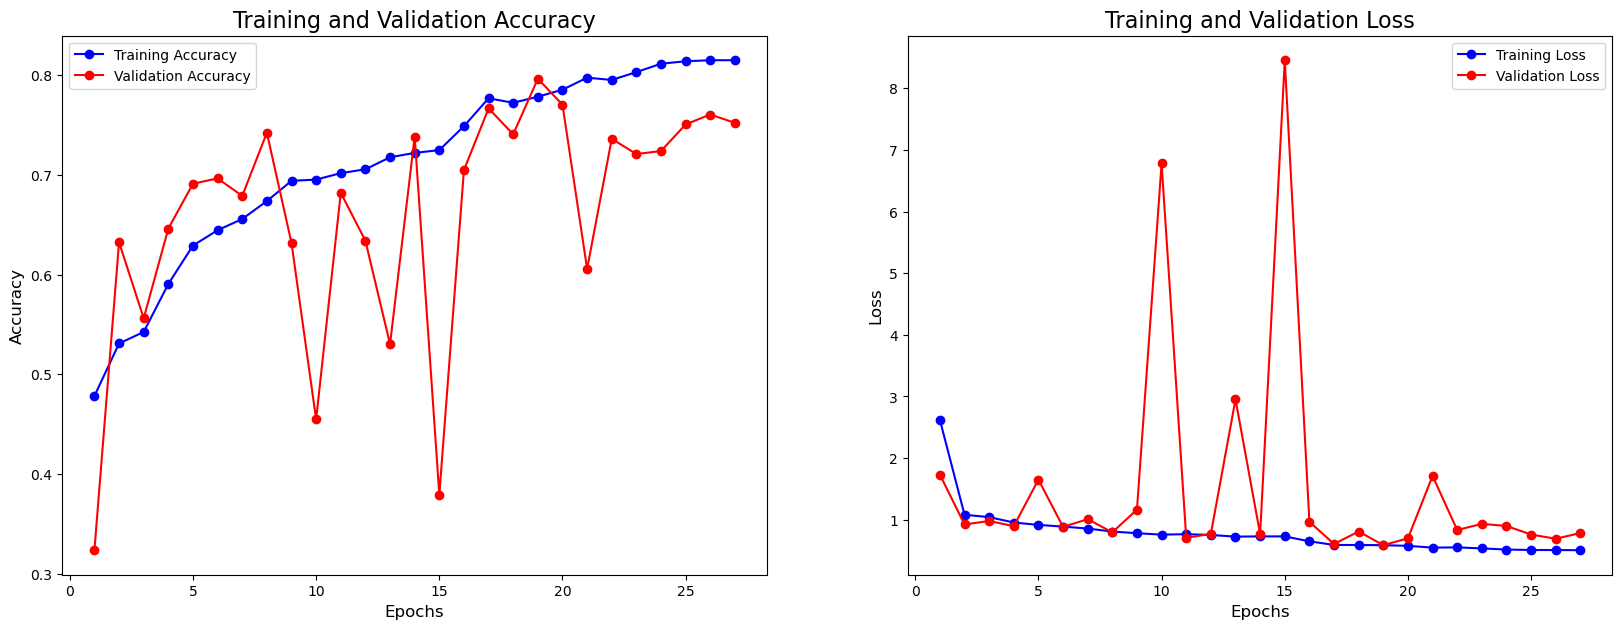


🤔 Confusion Matrix Visualization 🤔



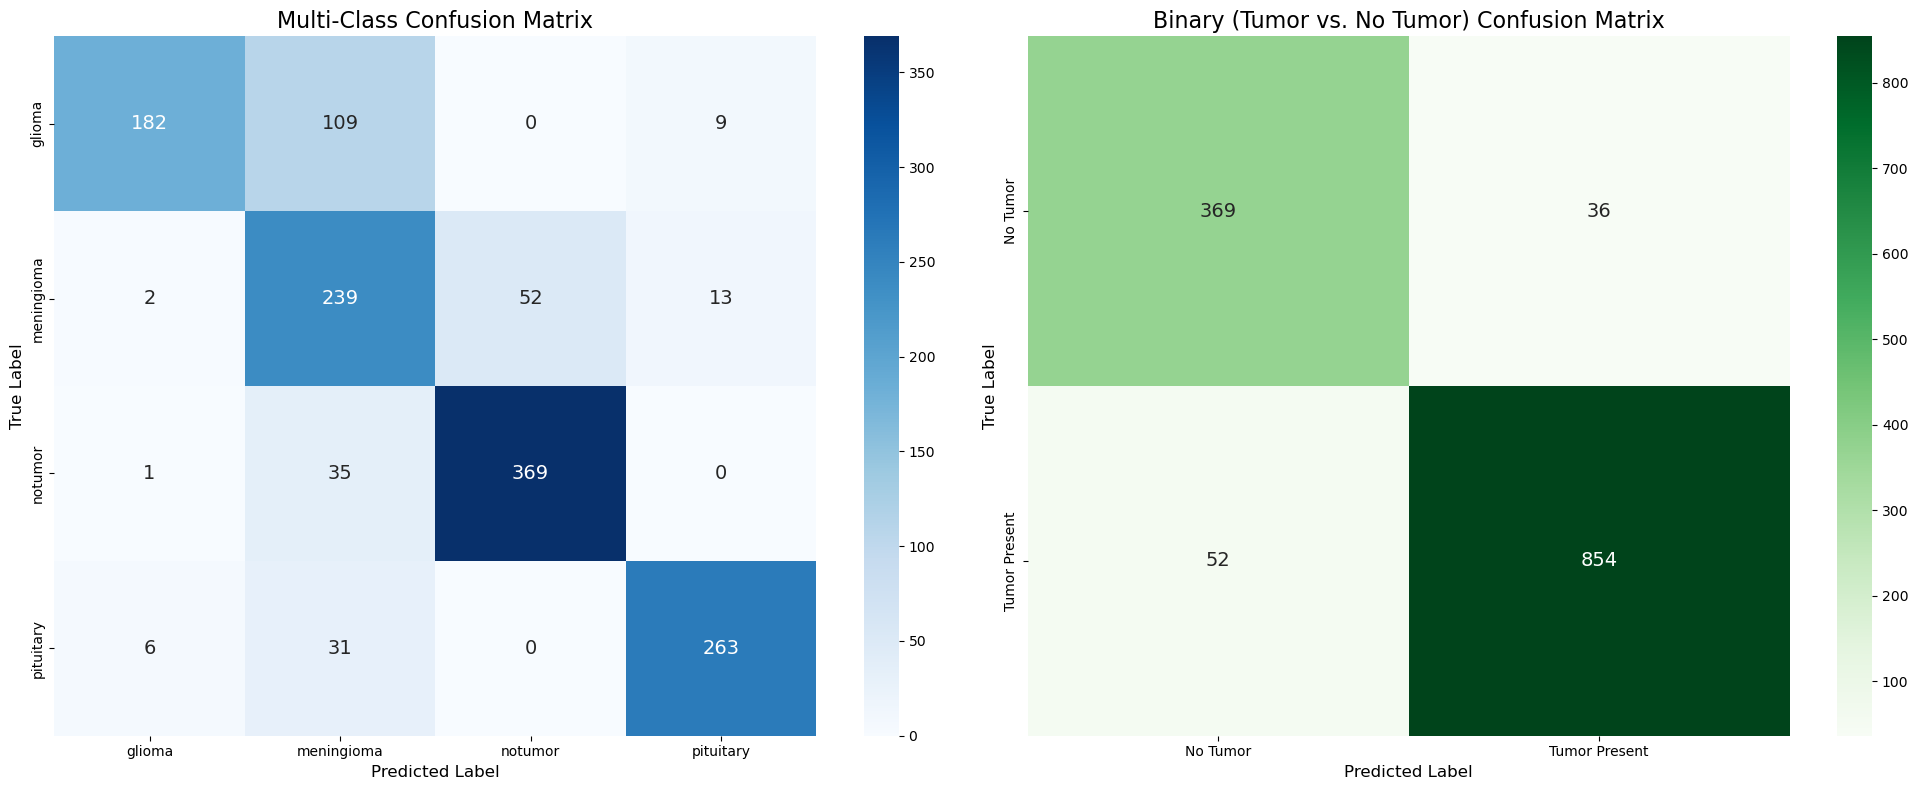


🖼️ Misclassified Images Visualization 🖼️



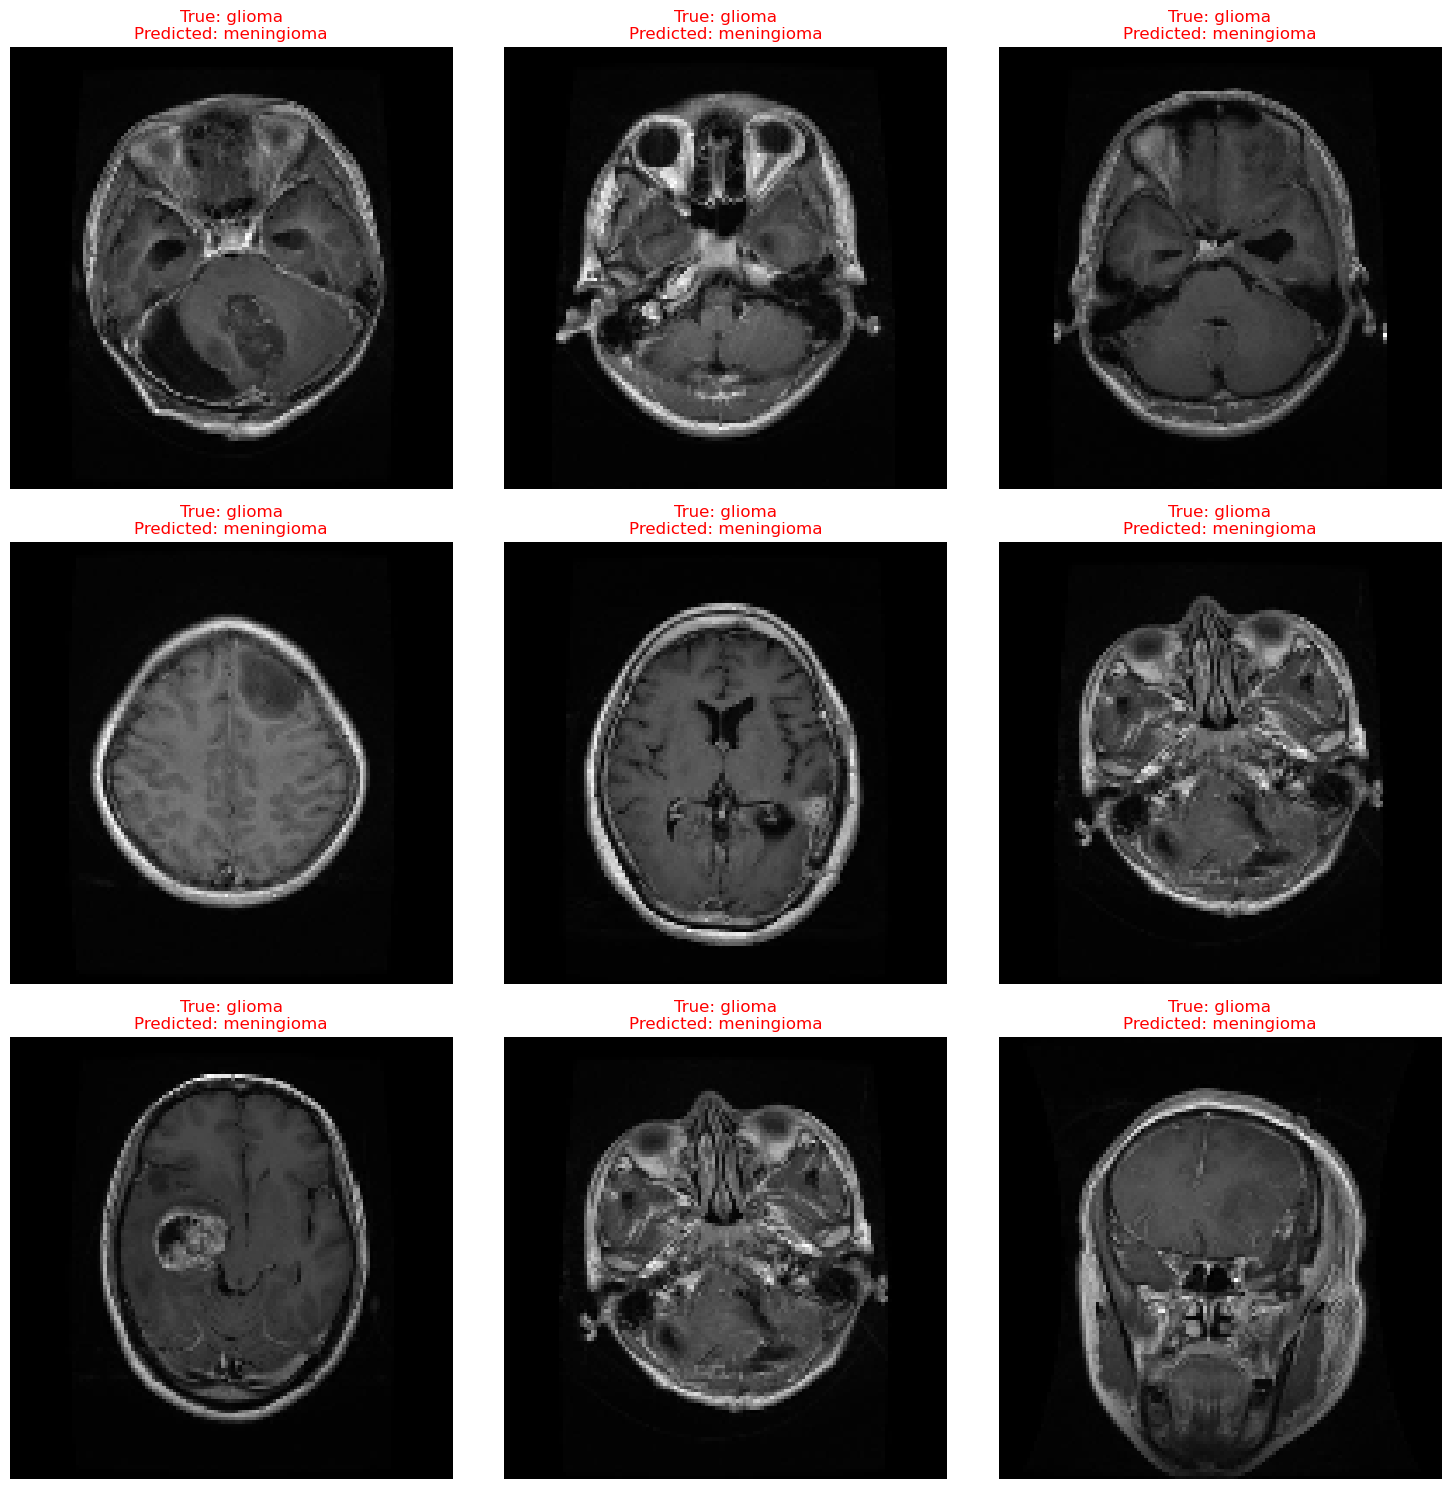

In [ ]:
# --- Add this entire block to the end of your last cell ---
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the training history from the 'history' object created during training
history_dict = history.history

# --- 1. Plot Training & Validation Accuracy and Loss ---
print("\n" + "="*50)
print("📈 Training History Visualization 📈")
print("="*50 + "\n")

# Check if training history is available
if 'accuracy' in history_dict and 'val_accuracy' in history_dict:
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(acc) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

    # Plot accuracy
    ax1.plot(epochs, acc, 'bo-', label='Training Accuracy')
    ax1.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend()

    # Plot loss
    ax2.plot(epochs, loss, 'bo-', label='Training Loss')
    ax2.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    ax2.set_title('Training and Validation Loss', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend()

    plt.show()
else:
    print("Training history not available.")


# --- 2. Plot Confusion Matrices ---
print("\n" + "="*50)
print(" Confusion Matrix Visualization")
print("="*50 + "\n")

# Create a figure for the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Multi-class confusion matrix
cm_multi = confusion_matrix(y_test, y_pred_fused)
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 14})
ax1.set_title('Multi-Class Confusion Matrix', fontsize=16)
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)

# Binary confusion matrix
cm_binary = confusion_matrix(y_test_binary, y_pred_binary)
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=binary_class_names, yticklabels=binary_class_names, annot_kws={"size": 14})
ax2.set_title('Binary (Tumor vs. No Tumor) Confusion Matrix', fontsize=16)
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()


# --- 3. Visualize Misclassified Images ---
print("\n" + "="*50)
print("Misclassified Images Visualization")
print("="*50 + "\n")

misclassified_indices = np.where(y_test != y_pred_fused)[0]
if len(misclassified_indices) > 0:
    plt.figure(figsize=(15, 15))
    # Display up to 9 misclassified images
    for i, idx in enumerate(misclassified_indices[:9]):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X_test[idx].squeeze(), cmap='gray')
        true_label = class_names[y_test[idx]]
        pred_label = class_names[y_pred_fused[idx]]
        plt.title(f"True: {true_label}\nPredicted: {pred_label}", color='red', fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("🎉 No misclassified images to display! Model was 100% accurate. 🎉")